### Gesture Index Mapping

| Index | Gesture | Description                        |
|-------|---------|------------------------------------|
| 0     | LP      | Lateral prehension                 |
| 1     | TA      | Thumb adduction                    |
| 2     | TLFO    | Thumb and little finger opposition |
| 3     | TIFO    | Thumb and index finger opposition  |
| 4     | TLFE    | Thumb and little finger extension  |
| 5     | TIFE    | Thumb and index finger extension   |
| 6     | IMFE    | Index and middle finger extension  |
| 7     | LFE     | Little finger extension            |
| 8     | IFE     | Index finger extension             |
| 9     | TE      | Thumb extension                    |
| 10    | WF      | Wrist flexion                      |
| 11    | WE      | Wrist extension                    |
| 12    | FP      | Forearm pronation                  |
| 13    | FS      | Forearm supination                 |
| 14    | HO      | Hand open                          |
| 15    | HC      | Hand close                         |
| 16    | REST    | Rest / No movement                 |
- The order of the 16 gestures was randomized and a resting (REST) trial was collected after all 16 gestures were performed once. 
- A ten-seconds relaxing period was provided between each trial. 

## 2.1 - Basic structure comfirmation
- verify sampling rate for Nyquist limit (assume T = 5sec and f_s = N/T (N = # of samples, T = period))
- create a channel inventory (Forearm_1–16, Wrist_1–12)
- check for signal amplitude
    - Amplitude sanity: robust P5–P95, MAD, RMS.
    - Clipping/saturation: % samples near edge, flat runs.
- Welch PSD: main energy 20–450 Hz.
- Powerline: check 50/60 Hz residuals (and harmonics).
- Usable band fraction: ≥70% of power in 20–450 Hz.
- Summaries & visuals
    - RMS & envelope: 2–3 representative channels, per trial.
    - Consistency check: RMS variation across trials of same gesture.
    - Plots:
        - Mosaic raw traces (all 28 channels).
        - PSD (one forearm + one wrist).
        - Envelope overlay.
        - Heatmap of RMS (channels × trials).
- Acceptance gates
    - Hard fail: wrong fs/duration, NaN/Inf, clipping >0.1%, missing channels.
    - Soft flag: low band power (<70%), poor notch, high trial variability.



<details>
<summary>Raw notes (click to expand)</summary>

check for amplitude, duration, sampling rate
    - amplitude: make sure that there r no clipping or SATURATION
    - infer duration from checking the graph on whether there r values after 5sec
    - validate sampling rate 
- whether the powerline noise still exist after the 60Hz notch filter
- Dshow that dataset shape is: 7 trials × 17 gestures
- show all 28 channels (16 forearm + 12 wrist) in a single trial -> # use n_channel = 30 to see examine abnormal

> things unsure to put in or not

- mean EMG activity?
- PSD?
- EMG Envolope? 
- RMS?

3) Robust amplitude band: P5–P95 and MAD -> this could replace the min/max which is outlier sensitive 
Why:
Raw min/max are fragile: one spike can blow them up. A robust spread (percentiles + MAD) tells you where most of the signal lives, resisting outliers.
What:
P5 and P95: the central 90% amplitude band.
MAD (median absolute deviation): robust noise/variability proxy.
How:
Compute P5, P95, MAD on raw volts (or µV/mV—use header units).
Sanity for sEMG: typical resting RMS tens of µV; active contractions often a few hundred µV RMS; peak-to-peak below ~10 mV for surface EMG in most setups. If P95 is “volts”, your scale is wrong.
Standard?
Robust stats are common in EMG QA and general biosignal QC to avoid spike bias.

7) Usable band power fraction (20–450 Hz)
Why:
sEMG lives predominantly in ~20–450 Hz. If most power is below 20 Hz, you’re seeing motion/sweat artefacts; if it’s above 450–500 Hz, you’ve got high-frequency noise (EMI, digital).
What:
Fraction of total power that sits inside the EMG band.
How:
Use the same Welch PSD as above.
Compute P_band = ∫_{20}^{450} PSD(f) df.
Compute P_total = ∫_{0}^{fs/2} PSD(f) df (or 1–900 Hz if you want to ignore DC).
Fraction F = P_band / P_total. Flag if F < 0.70 (70%).
Standard?
Band-limited power fractions (or spectral moments) are common in EMG QA and are a simple, interpretable summary.

<details>


Found 129 .mat files
Selected file: session3_participant41.mat
Visualizing Gesture: TLFO (Trial 5)
Forearm Sampling Rate: 2048.0 Hz | Wrist Sampling Rate: 2048.0 Hz


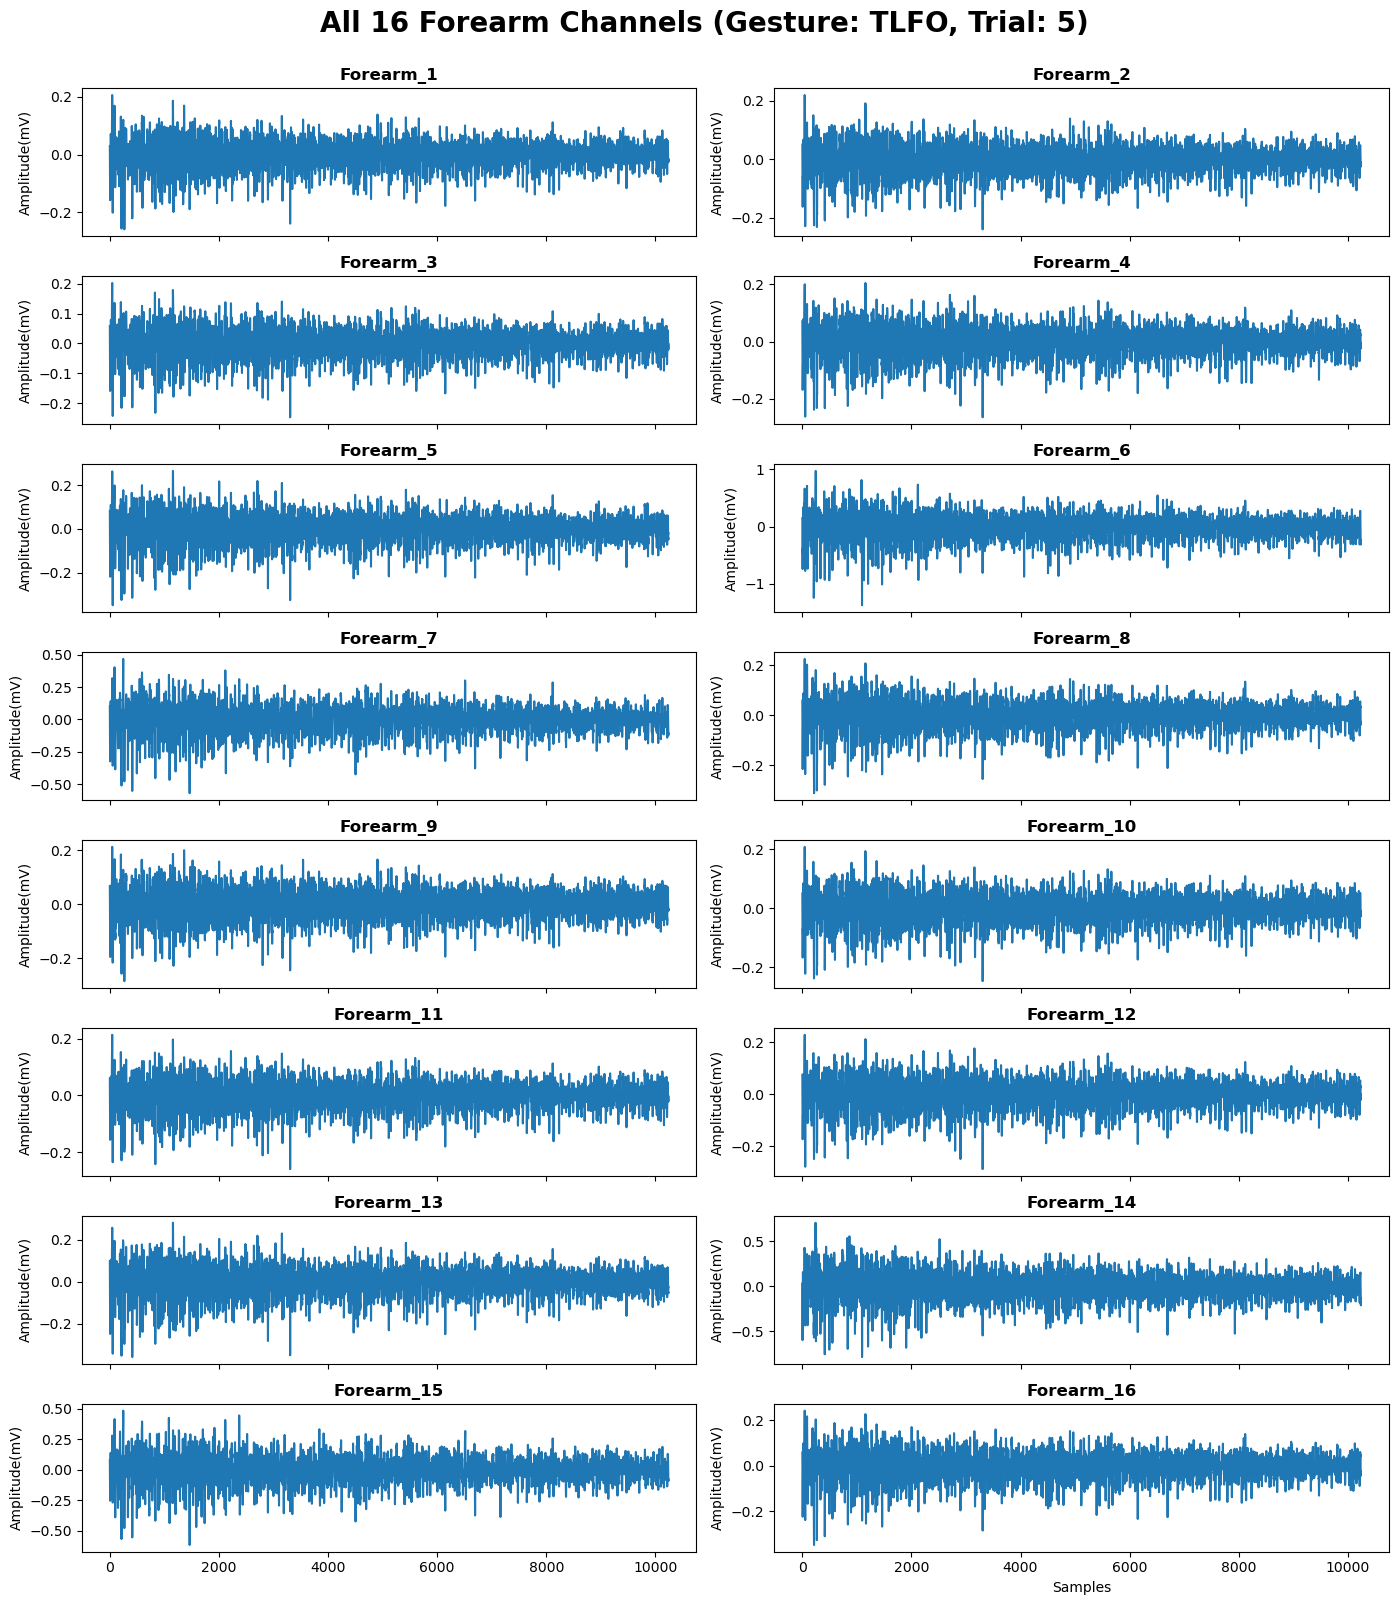

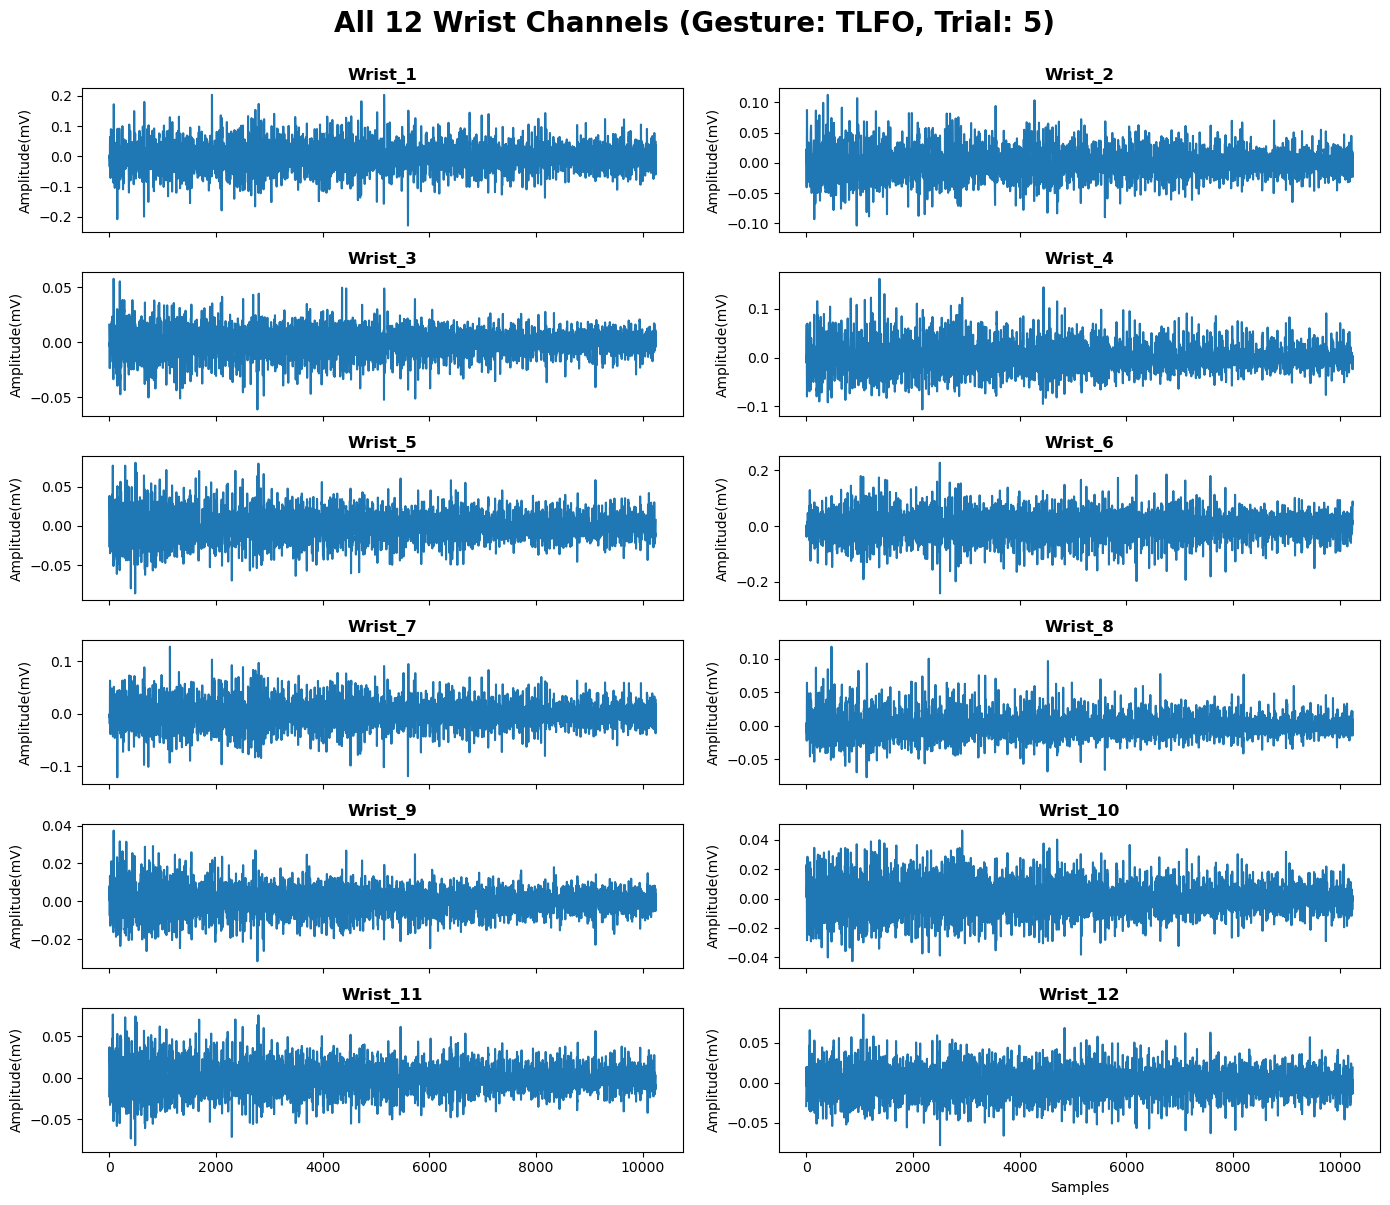

In [10]:
import numpy as np
import scipy.io as sio
from pathlib import Path
import matplotlib.pyplot as plt
import random
from natsort import natsorted


# Set all EMG folders here
folders = [
    "/Users/jasonwang/Desktop/Wearable/EMG_Project/grabmyo_1.1.0/OutputBM/Session1_converted",
    "/Users/jasonwang/Desktop/Wearable/EMG_Project/grabmyo_1.1.0/OutputBM/Session2_converted",
    "/Users/jasonwang/Desktop/Wearable/EMG_Project/grabmyo_1.1.0/OutputBM/Session3_converted"
 ]

# Collect all .mat files
mat_files = []
for folder in folders:
    mat_files.extend(natsorted(list(Path(folder).glob("*.mat"))))

print(f"\nFound {len(mat_files)} .mat files")

# Define gesture labels
gestures = [
    "LP", "TA", "TLFO", "TIFO", "TLFE", "TIFE", "IMFE", "LFE",
    "IFE", "TE", "WF", "WE", "FP", "FS", "HO", "HC", "REST"
]

# Choose what file to load:
sample_file = random.choice(mat_files)                                              # Option 1: Random file
# sample_file = mat_files[0]                                                        # Option 2: By file index
# sample_file = [f for f in mat_files if "session1_participant1.mat" in str(f)]     # Option 3: By name

print(f"Selected file: {sample_file.name}")
data = sio.loadmat(sample_file)

# Total number of trials and gestures
num_trials = 7
num_gestures = 17

# Option to choose random or specific indices
use_random = True  # Set to False to assign specific indices
if use_random: #randomly select a trial and gesture
    trial_idx = random.randint(0, num_trials - 1)
    gesture_idx = random.randint(0, num_gestures - 1)
else:
    trial_idx = 0  # Example: First trial
    gesture_idx = 16  # Example: 17th gesture (REST)
    # Ensure indices are within valid range
    assert 0 <= trial_idx < num_trials, f"trial_idx must be between 0 and {num_trials - 1}"
    assert 0 <= gesture_idx < num_gestures, f"gesture_idx must be between 0 and {num_gestures - 1}"   

# Load forearm and wrist data for the selected trial and gesture
forearm = data['DATA_FOREARM'][trial_idx, gesture_idx]
wrist = data['DATA_WRIST'][trial_idx, gesture_idx]
channels = [f'Forearm_{i+1}' for i in range(16)] + [f'Wrist_{i+1}' for i in range(12)]

# Get the gesture name
gesture_name = gestures[gesture_idx]
print(f"Visualizing Gesture: {gesture_name} (Trial {trial_idx + 1})")

# Generalized function to calculate sampling rate and time axis
def calculate_fs_and_time(data, T):
    N = data.shape[0]  # Number of samples
    fs = N / T  # Sampling rate
    time = np.linspace(0, T, N)  # Time axis
    return fs, time

# Duration of the recording
T = 5  # Duration in seconds

# Calculate sampling rate and time axis for forearm
fs_forearm, time_forearm = calculate_fs_and_time(forearm, T)

# Calculate sampling rate and time axis for wrist
fs_wrist, time_wrist = calculate_fs_and_time(wrist, T)
print(f"Forearm Sampling Rate: {fs_forearm} Hz | Wrist Sampling Rate: {fs_wrist} Hz")

# Plot all 16 forearm channels in subplots
fig, axes = plt.subplots(8, 2, figsize=(14, 16), sharex=True)
axes = axes.flatten()
for i in range(16):
    axes[i].plot(forearm[:, i])
    axes[i].set_title(channels[i], fontweight='bold')
    axes[i].set_ylabel('Amplitude(mV)')
axes[-1].set_xlabel('Samples')
plt.suptitle(f'All 16 Forearm Channels (Gesture: {gesture_name}, Trial: {trial_idx + 1})', y=1, fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

# Plot all 12 wrist channels in subplots
fig, axes = plt.subplots(6, 2, figsize=(14, 12), sharex=True)
axes = axes.flatten()
for i in range(12):
    axes[i].plot(wrist[:, i])
    axes[i].set_title(channels[i + 16], fontweight='bold')
    axes[i].set_ylabel('Amplitude(mV)')
axes[-1].set_xlabel('Samples')
plt.suptitle(f'All 12 Wrist Channels (Gesture: {gesture_name}, Trial: {trial_idx + 1})', y=1, fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()


In [52]:
from scipy.stats import median_abs_deviation
import pandas as pd

# Function to calculate P5-P95, MAD, and RMS
def calculate_signal_metrics(data):
    p5 = float(np.percentile(data, 5))
    p95 = float(np.percentile(data, 95))
    mad = float(median_abs_deviation(data))
    rms = float(np.sqrt(np.mean(data**2)))
    return {'P5': p5, 'P95': p95, 'MAD': mad, 'RMS': rms}

# # if needs to load other specific file diff from above:
# sample_file = random.choice(mat_files)                                              # Option 1: Random file
# # sample_file = mat_files[0]                                                        # Option 2: By file index
# # sample_file = [f for f in  mat_files if "session1_participant1.mat" in str(f)]     # Option 3: By name
# data = sio.loadmat(sample_file)

# # Total number of trials and gestures
# num_trials = 7
# num_gestures = 17

# # Option to choose random or specific indices
# use_random = True  # Set to False to assign specific indices
# if use_random: #randomly select a trial and gesture
#     trial_idx = random.randint(0, num_trials - 1)
#     gesture_idx = random.randint(0, num_gestures - 1)
# else:
#     trial_idx = 0  # Example: First trial
#     gesture_idx = 16  # Example: 17th gesture (REST)
#     # Ensure indices are within valid range
#     assert 0 <= trial_idx < num_trials, f"trial_idx must be between 0 and {num_trials - 1}"
#     assert 0 <= gesture_idx < num_gestures, f"gesture_idx must be between 0 and {num_gestures - 1}"   

# # Load forearm and wrist data for the selected trial and gesture
# forearm = data['DATA_FOREARM'][trial_idx, gesture_idx]
# wrist = data['DATA_WRIST'][trial_idx, gesture_idx]
# channels = [f'Forearm_{i+1}' for i in range(16)] + [f'Wrist_{i+1}' for i in range(12)]

print(f"Selected file: {sample_file.name}")

# Get the gesture name
gesture_name = gestures[gesture_idx]
print(f"Visualizing Gesture: {gesture_name} (gesture {gesture_idx}) - Trial {trial_idx + 1}")

# Calculate and display metrics for forearm channels
forearm_metrics = [calculate_signal_metrics(forearm[:, ch]) for ch in range(forearm.shape[1])]
forearm_df = pd.DataFrame(forearm_metrics)
forearm_df.index = [f"Forearm_{i+1}" for i in range(forearm.shape[1])]
display(forearm_df.style.format("{:.2f}").background_gradient(cmap="Greens"))

# Calculate and display metrics for wrist channels
wrist_metrics = [calculate_signal_metrics(wrist[:, ch]) for ch in range(wrist.shape[1])]
wrist_df = pd.DataFrame(wrist_metrics)
wrist_df.index = [f"Wrist_{i+1}" for i in range(wrist.shape[1])]
display(wrist_df.style.format("{:.2f}").background_gradient(cmap="Blues"))


Selected file: session3_participant41.mat
Visualizing Gesture: TLFO (gesture 2) - Trial 5


,P5,P95,MAD,RMS
Forearm_1,-0.08,0.07,0.03,0.05
Forearm_2,-0.08,0.07,0.03,0.05
Forearm_3,-0.08,0.07,0.03,0.05
Forearm_4,-0.09,0.08,0.03,0.05
Forearm_5,-0.11,0.10,0.04,0.06
Forearm_6,-0.34,0.30,0.12,0.20
Forearm_7,-0.18,0.16,0.06,0.11
Forearm_8,-0.09,0.08,0.03,0.05
Forearm_9,-0.09,0.08,0.03,0.05
Forearm_10,-0.08,0.07,0.03,0.05


,P5,P95,MAD,RMS
Wrist_1,-0.07,0.06,0.02,0.04
Wrist_2,-0.04,0.04,0.01,0.02
Wrist_3,-0.02,0.02,0.01,0.01
Wrist_4,-0.04,0.05,0.02,0.03
Wrist_5,-0.03,0.03,0.01,0.02
Wrist_6,-0.07,0.07,0.02,0.04
Wrist_7,-0.04,0.04,0.01,0.02
Wrist_8,-0.02,0.03,0.01,0.02
Wrist_9,-0.01,0.01,0.00,0.01
Wrist_10,-0.02,0.02,0.01,0.01


## 2.2 - diff gesture comparison 
> Show that different gestures produce distinguishable muscle activity (same participants diff channel)

## 2.3 -  Multiple trials from one gesture

## Old code archives

<details>
<summary> old code for basic stucture v1 </summary>

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from pathlib import Path
from natsort import natsorted

data_path = Path("/Users/jasonwang/Desktop/Wearable/EMG_Project/grabmyo_1.1.0/OutputBM/Session1_converted")
mat_files = natsorted(list(data_path.glob("*.mat"))) # use natsorted to sort files as 1, 2, 3, ... instead of 1, 10, 2, 20, 3,...

# Load and inspect a sample .mat file
if mat_files:
    sample_file = mat_files[0]
    print(f"\nExamining file: {sample_file.name}")
    participant_file = sio.loadmat(sample_file) # load .mat file with scipy


def calculate_sampling_rate(participant_file, expected_duration=5.0):
    """Calculate sampling rate from data shape."""
    n_samples = participant_file.shape[0]
    return n_samples / expected_duration

def plot_emg_overview(participant_file, participant_id, gesture_idx=0, trial_idx=0, n_channels=4):
    """Create comprehensive EMG visualization with calculated parameters."""
    
    # Extract data
    forearm_emg = participant_file['DATA_FOREARM'][trial_idx, gesture_idx]
    wrist_emg = participant_file['DATA_WRIST'][trial_idx, gesture_idx]
    
    # Calculate actual sampling rate instead of hardcoding
    sampling_rate = calculate_sampling_rate(forearm_emg)
    
    # Combine data
    all_emg = np.concatenate([forearm_emg, wrist_emg], axis=1)
    time_axis = np.arange(all_emg.shape[0]) / sampling_rate
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_channels//2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    # Plot channels with clear labeling
    for i in range(min(n_channels, all_emg.shape[1])):
        row, col = divmod(i, 2)
        
        # Determine channel source
        if i < forearm_emg.shape[1]:
            channel_label = f'Forearm Ch{i+1}'
            color = 'blue'
        else:
            channel_label = f'Wrist Ch{i-forearm_emg.shape[1]+1}'
            color = 'red'
            
        axes[i].plot(time_axis, all_emg[:, i], color=color, alpha=0.8)
        axes[i].set_title(channel_label)
        axes[i].set_ylabel('Amplitude (mV)')
        axes[i].grid(True, alpha=0.3)
        
        if i >= n_channels - 2:  # Bottom row
            axes[i].set_xlabel('Time (s)')
    
    plt.suptitle(f'EMG Signals - Participant {participant_id}, Gesture {gesture_idx+1}, Trial {trial_idx+1}\n'
                f'Sampling Rate: {sampling_rate:.0f} Hz, Duration: {time_axis[-1]:.1f}s', y=0.98)
    plt.tight_layout()
    return fig, sampling_rate

def compare_gestures(participant_file, participant_id, gestures=[0, 1, 2], trial_idx=0):
    """Compare the same trial across different gestures."""
    
    fig, axes = plt.subplots(len(gestures), 1, figsize=(12, 8))
    if len(gestures) == 1:
        axes = [axes]
    
    for i, gesture_idx in enumerate(gestures):
        forearm_emg = participant_file['DATA_FOREARM'][trial_idx, gesture_idx]
        wrist_emg = participant_file['DATA_WRIST'][trial_idx, gesture_idx]
        all_emg = np.concatenate([forearm_emg, wrist_emg], axis=1)
        
        sampling_rate = calculate_sampling_rate(forearm_emg)
        time_axis = np.arange(all_emg.shape[0]) / sampling_rate
        
        # Plot mean activity across all channels
        mean_activity = np.abs(all_emg).mean(axis=1)
        axes[i].plot(time_axis, mean_activity)
        axes[i].set_title(f'Gesture {gesture_idx+1} - Mean EMG Activity')
        axes[i].set_ylabel('Mean |Amplitude| (mV)')
        axes[i].grid(True, alpha=0.3)
        
        if i == len(gestures) - 1:
            axes[i].set_xlabel('Time (s)')
    
    plt.suptitle(f'Gesture Comparison - Participant {participant_id}, Trial {trial_idx+1}')
    plt.tight_layout()
    return fig

def get_data_summary(participant_file):
    """Get comprehensive data summary without hardcoding."""
    forearm_shape = participant_file['DATA_FOREARM'].shape
    wrist_shape = participant_file['DATA_WRIST'].shape

    # Get sample recording info
    sample_forearm = participant_file['DATA_FOREARM'][0, 0]
    sample_wrist = participant_file['DATA_WRIST'][0, 0]

    sampling_rate = calculate_sampling_rate(sample_forearm)
    duration = sample_forearm.shape[0] / sampling_rate
    
    summary = {
        'trials': forearm_shape[0],
        'gestures': forearm_shape[1], 
        'forearm_channels': sample_forearm.shape[1],
        'wrist_channels': sample_wrist.shape[1],
        'total_channels': sample_forearm.shape[1] + sample_wrist.shape[1],
        'samples_per_recording': sample_forearm.shape[0],
        'sampling_rate': sampling_rate,
        'duration': duration
    }
    
    return summary

# Usage example (replace with your loaded data)
summary = get_data_summary(participant_file)
print(f"Dataset: {summary['trials']} trials × {summary['gestures']} gestures")
print(f"Channels: {summary['forearm_channels']} forearm + {summary['wrist_channels']} wrist = {summary['total_channels']} total")
print(f"Recording: {summary['samples_per_recording']} samples, {summary['duration']:.1f}sec @ {summary['sampling_rate']:.0f} Hz")

fig1, sr = plot_emg_overview(participant_file, participant_id=1, gesture_idx=0, trial_idx=0)
fig2 = compare_gestures(participant_file, participant_id=1, gestures=[0, 1, 2, 3])
plt.show()

<details>
<summary>old code for basic strucutre v2</summary>

# ===== Step 1: Basic structure & integrity =====
from pathlib import Path
import numpy as np
import scipy.io as sio
from scipy.signal import butter, filtfilt, welch
import matplotlib.pyplot as plt
import pandas as pd

# ------- paths & expected settings -------
PARTICIPANT_FILE = Path("/Users/jasonwang/Desktop/Wearable/EMG_Project/grabmyo_1.1.0/OutputBM/Session1_converted/session1_participant22.mat")
FS = 2048  # Hz (adjust if your metadata says otherwise)

# ------- helpers -------
def load_grabmyo_participant(mat_path):
    """Return (forearm_obj, wrist_obj) arrays of shape (trials=7, gestures=17), each cell is (time, channels)."""
    D = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    fore = D.get('DATA_FOREARM'); wrist = D.get('DATA_WRIST')
    assert fore is not None and wrist is not None, "Missing DATA_FOREARM / DATA_WRIST in file."
    return fore, wrist

def ensure_time_by_channels(X):
    # Many MATLAB exports are channels x time; we want time x channels.
    return X if X.shape[0] >= X.shape[1] else X.T

def get_trial(fore_obj, wrist_obj, trial_idx=0, gesture_idx=0, concat=True):
    Xf = ensure_time_by_channels(fore_obj[trial_idx, gesture_idx])
    Xw = ensure_time_by_channels(wrist_obj[trial_idx, gesture_idx])
    X = np.concatenate([Xf, Xw], axis=1) if concat else None
    return Xf, Xw, X

def butter_bandpass(x, fs, lo=20, hi=450, order=4):
    b,a = butter(order, [lo/(fs/2), hi/(fs/2)], btype='band')
    return filtfilt(b, a, x, axis=0)

def butter_lowpass(x, fs, cutoff=10, order=4):
    b,a = butter(order, cutoff/(fs/2), btype='low')
    return filtfilt(b, a, x, axis=0)

def emg_envelope(x, fs, bp_lo=20, bp_hi=450, env_lp=10):
    x_bp = butter_bandpass(x, fs, bp_lo, bp_hi)
    x_env = butter_lowpass(np.abs(x_bp), fs, env_lp)
    return x_bp, x_env

def clipping_metrics(x, fs, edge_frac=0.005, flat_ms=5):
    """%samples near extremes + number of long flat runs at extremes (≥ flat_ms)."""
    x = np.asarray(x)
    xmin, xmax = float(np.min(x)), float(np.max(x))
    span = xmax - xmin if xmax > xmin else 1.0
    tol = edge_frac * span
    near_min = np.sum(x <= xmin + tol)
    near_max = np.sum(x >= xmax - tol)
    pct_edge = 100.0 * (near_min + near_max) / x.size

    # flat runs at extremes
    L = max(1, int(flat_ms * 1e-3 * fs))
    flat_runs = 0
    for extreme_mask in [(x <= xmin + tol), (x >= xmax - tol)]:
        run = 0
        for v in extreme_mask:
            if v: run += 1
            else:
                if run >= L: flat_runs += 1
                run = 0
        if run >= L: flat_runs += 1
    return dict(pct_edge=pct_edge, flat_runs=flat_runs)

def channel_summary(X, fs):
    rows = []
    for ch in range(X.shape[1]):
        x = X[:, ch]
        clip = clipping_metrics(x, fs)
        rows.append(dict(
            channel=ch,
            min=float(np.min(x)),
            max=float(np.max(x)),
            rms=float(np.sqrt(np.mean(x**2))),
            pct_near_edge=clip['pct_edge'],
            flat_runs=clip['flat_runs'],
            has_nan=bool(np.isnan(x).any()),
            has_inf=bool(np.isinf(x).any())
        ))
    return pd.DataFrame(rows)

def quick_psd(x, fs):
    f, pxx = welch(x, fs=fs, nperseg=1024, noverlap=512)
    return f, pxx

# ------- load one trial for integrity checks -------
fore, wrist = load_grabmyo_participant(PARTICIPANT_FILE)

trial_idx   = 0  # 0..6
gesture_idx = 0  # 0..16  (include 'rest' later when you know the index)

Xf, Xw, X = get_trial(fore, wrist, trial_idx, gesture_idx, concat=True)

# ------- fs & duration checks -------
N = X.shape[0]
duration_s = N / FS
print(f"[INFO] samples={N}, FS={FS} Hz → duration≈{duration_s:.3f} s, channels={X.shape[1]}")

# If you *assume* 5 s trials, estimate fs from N and warn if off:
fs_est = round(N / 5.0)
if abs(fs_est - FS) > 5:
    print(f"[WARN] If trial is ~5 s, estimated fs={fs_est} Hz differs from FS={FS} Hz. Double-check metadata.")

# ------- per-channel integrity summary -------
summ = channel_summary(X, FS)
display(summ.head(10))
print(f"[CHECK] Any NaN? {summ.has_nan.any()} | Any Inf? {summ.has_inf.any()}")
clipping_any = (summ.pct_near_edge > 0.5).any() or (summ.flat_runs > 0).any()
print(f"[CHECK] Any clipping flags? {clipping_any}")

# ------- choose representative channels (2 forearm + 1 wrist) -------
n_fore = 16  # adjust if your file differs
ch_sel = [0, min(n_fore-1, X.shape[1]-1), min(n_fore, X.shape[1]-1)]

# ------- visual: raw (zoom 2 s window) -------
t = np.arange(N) / FS
t0, t1 = 0.5, 2.5
mask = (t >= t0) & (t <= t1)

fig, ax = plt.subplots(len(ch_sel), 1, figsize=(8, 5), sharex=True)
for i, ch in enumerate(ch_sel):
    ax[i].plot(t[mask], X[mask, ch])
    ax[i].set_ylabel(f'ch {ch}')
ax[-1].set_xlabel('Time (s)')
fig.suptitle('Raw EMG (zoomed view)')
plt.tight_layout()
plt.show()

# ------- spectral sanity (Welch PSD) -------
f, pxx = quick_psd(X[:, ch_sel[0]], FS)
plt.figure(figsize=(6,3))
plt.semilogy(f, pxx)
plt.axvline(50, ls='--', alpha=0.5)  # UK mains
plt.xlim(0, 600)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.title(f'PSD (channel {ch_sel[0]})')
plt.tight_layout()
plt.show()

# ------- envelope view (band-pass → rectify → low-pass) -------
X_bp, X_env = emg_envelope(X[:, ch_sel], FS)
plt.figure(figsize=(8,3))
plt.plot(t, X_env)
plt.xlim(0, duration_s)
plt.xlabel('Time (s)')
plt.ylabel('Envelope (a.u.)')
plt.title(f'EMG envelopes (channels {ch_sel})')
plt.tight_layout()
plt.show()

# ------- optional: save summary -------
outdir = Path("results/eda/step1")
outdir.mkdir(parents=True, exist_ok=True)
summ.to_csv(outdir / "integrity_summary.csv", index=False)
print(f"[SAVED] {outdir/'integrity_summary.csv'}")


<details>
<summary> old code for basic stucture v3 </summary>

# emg_qc_notebook.py
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Dict, Tuple, List, Optional, Any
from scipy.io import loadmat
from scipy.signal import welch, butter, filtfilt

# ----------------------- Header parsing -----------------------

@dataclass
class HeaderInfo:
    fs: Optional[float] = None
    labels: List[str] = field(default_factory=list)
    units: Optional[str] = None

def parse_wfdb_header(hea_path: Path) -> HeaderInfo:
    info = HeaderInfo()
    if not hea_path or not hea_path.exists():
        return info
    text = hea_path.read_text(errors="ignore")
    lines = [ln.strip() for ln in text.splitlines() if ln.strip()]
    if not lines:
        return info
    toks = lines[0].split()
    if len(toks) >= 3:
        try:
            info.fs = float(toks[2])
        except Exception:
            pass
    labels, units = [], []
    import re
    for ln in lines[1:]:
        parts = ln.split()
        if parts:
            labels.append(parts[-1])
        m = re.search(r"/([a-zA-ZµuV]+)\b", ln)
        if m:
            units.append(m.group(1))
    info.labels = labels
    if len(units) == len(labels) and len(units) > 0 and len(set(units)) == 1:
        info.units = units[0]
    return info

# ----------------------- Small helpers -----------------------

def robust_stats(x: np.ndarray) -> Dict[str, float]:
    x = np.asarray(x).astype(float)
    p5  = float(np.percentile(x, 5))
    p95 = float(np.percentile(x, 95))
    mad = float(np.median(np.abs(x - np.median(x))))
    rms = float(np.sqrt(np.mean(x**2)))
    return {"P5": p5, "P95": p95, "MAD": mad, "RMS": rms}

def clipping_metrics(x: np.ndarray, edge_frac: float = 0.005) -> Dict[str, float]:
    x = np.asarray(x).astype(float)
    xmin, xmax = float(np.min(x)), float(np.max(x))
    rng = xmax - xmin
    if rng == 0:
        return {"pct_near_edge": 100.0, "max_flat_run": float(len(x))}
    thr_low  = xmin + edge_frac * rng
    thr_high = xmax - edge_frac * rng
    pct_near = float(np.mean((x <= thr_low) | (x >= thr_high))) * 100.0
    diffs = np.diff(x)
    flat = np.where(diffs == 0)[0]
    if flat.size == 0:
        max_run = 1.0
    else:
        runs, run = [], 1
        for i in range(1, len(flat)):
            if flat[i] == flat[i-1] + 1: run += 1
            else: runs.append(run); run = 1
        runs.append(run)
        max_run = float(max(runs) + 1)
    return {"pct_near_edge": pct_near, "max_flat_run": max_run}

def compute_psd_features(x: np.ndarray, fs: float) -> Dict[str, float]:
    f, Pxx = welch(x.astype(float), fs=fs, nperseg=min(1024, len(x)))
    total = float(np.trapezoid(Pxx, f))
    band  = (f >= 20) & (f <= 450)
    p_band = float(np.trapezoid(Pxx[band], f[band])) if np.any(band) else 0.0
    frac = p_band / total if total > 0 else 0.0

    def local_peak_power(target_hz: float) -> float:
        bw = 1.0
        m = (f >= target_hz - bw) & (f <= target_hz + bw) & (f > 0)
        return float(np.max(Pxx[m])) if np.any(m) else 0.0

    band_vals = Pxx[band]
    med_band  = float(np.median(band_vals[band_vals > 0])) if np.any(band_vals > 0) else 1e-12
    peaks_50  = [local_peak_power(h) for h in (50, 100, 150)]
    peaks_60  = [local_peak_power(h) for h in (60, 120, 180)]
    max_mains = max(peaks_50 + peaks_60) if (peaks_50 + peaks_60) else 0.0
    mains_db  = 10.0 * np.log10(max(max_mains / (med_band + 1e-12), 1e-12))
    return {"usable_band_fraction": float(frac), "mains_residual_db": float(mains_db)}

def design_envelope_filters(fs: float):
    ny = fs / 2.0
    b_bp, a_bp = butter(4, [20/ny, 450/ny], btype='band')
    b_lp, a_lp = butter(4, 6/ny, btype='low')
    return (b_bp, a_bp), (b_lp, a_lp)

def envelope_signal(x: np.ndarray, fs: float, b_bp, a_bp, b_lp, a_lp) -> np.ndarray:
    x_bp = filtfilt(b_bp, a_bp, x)
    return filtfilt(b_lp, a_lp, np.abs(x_bp))

def stacked_plot_all_channels(x_cs: np.ndarray, fs: float, title: str,
                              notebook: bool = True, save_path: Optional[Path] = None):
    ch, n = x_cs.shape
    t = np.arange(n) / fs
    fig = plt.figure(figsize=(12, 8))
    ax = plt.gca()
    y0 = 0.0
    for i in range(ch):
        xi = x_cs[i]
        p95 = np.percentile(np.abs(xi), 95) if np.any(xi) else 1.0
        scale = p95 if p95 > 0 else 1.0
        ax.plot(t, xi/scale + y0, linewidth=0.6)
        y0 += 2.0
    ax.set_title(title)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Channel (stacked offsets)")
    ax.grid(True, linestyle='--', alpha=0.3)
    fig.tight_layout()
    if notebook:
        plt.show()
    else:
        fig.savefig(save_path, dpi=150, bbox_inches='tight'); plt.close(fig)
    return fig

def plot_psd_with_mains(x: np.ndarray, fs: float, title: str,
                        xlim: Tuple[float,float]=(0,750),
                        mains: Tuple[int,...]=(500,100,120,150,180),
                        notebook: bool=True, save_path: Optional[Path]=None):
    f, Pxx = welch(x.astype(float), fs=fs, nperseg=min(1024, len(x)))
    fig = plt.figure(figsize=(8,5)); ax = plt.gca()
    ax.semilogy(f, Pxx, linewidth=1.0)
    for mhz in mains:
        ax.axvline(mhz, linestyle='--', alpha=0.5)
        ax.text(mhz+3, ax.get_ylim()[1]/10, f"{mhz} Hz", rotation=90, va='top', fontsize=8)
    ax.set_xlim(*xlim)
    ax.set_title(title)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("PSD")
    ax.grid(True, linestyle='--', alpha=0.3)
    fig.tight_layout()
    if notebook:
        plt.show()
    else:
        fig.savefig(save_path, dpi=150, bbox_inches='tight'); plt.close(fig)
    return fig

# ----------------------- QA core -----------------------

@dataclass
class QAConfig:
    T_seconds: float = 5.0
    min_band_fraction: float = 0.70
    max_clipping_pct: float = 0.1
    mains_ok_db: float = 20.0      # notch ‘good’ if peak < −20 dB vs band median
    fs_tolerance_pct: float = 1.0  # header vs estimated

@dataclass
class QASummaryItem:
    trial: int
    gesture: int
    fs_est: float
    fs_header: Optional[float]
    n_channels: int
    hard_fail: List[str]
    soft_flags: List[str]

def load_grabmyo_mat(mat_path: Path) -> Tuple[np.ndarray, float]:
    d = loadmat(mat_path.as_posix(), squeeze_me=True, struct_as_record=False)
    d = {k: v for k, v in d.items() if not k.startswith("__")}
    if "DATA_FOREARM" not in d or "DATA_WRIST" not in d:
        raise RuntimeError("Expected DATA_FOREARM and DATA_WRIST in MAT.")
    DF, DW = d["DATA_FOREARM"], d["DATA_WRIST"]
    n_trials, n_gestures = DF.shape
    ex_f, ex_w = DF[0,0], DW[0,0]        # (samples, 16), (samples, 12)
    N = int(ex_f.shape[0]); fs_est = N / 5.0
    data4 = np.zeros((n_trials, n_gestures, 28, N), dtype=float)
    for i in range(n_trials):
        for j in range(n_gestures):
            fseg = DF[i, j].T     # (16, samples)
            wseg = DW[i, j].T     # (12, samples)
            data4[i, j] = np.concatenate([fseg, wseg], axis=0)  # (28, N)
    return data4, float(fs_est)

def qa_on_trial(x_cs: np.ndarray, fs: float, cfg: QAConfig) -> Dict[str, Any]:
    ch, _ = x_cs.shape
    rows, any_nan, any_clip, low_band, bad_mains = [], False, False, False, False
    for k in range(ch):
        x = x_cs[k].astype(float)
        if not np.isfinite(x).all(): any_nan = True
        rs = robust_stats(x)
        cm = clipping_metrics(x)
        ps = compute_psd_features(x, fs)
        rows.append({"Channel": k+1, **rs, **cm, **ps})
        if cm["pct_near_edge"] > cfg.max_clipping_pct: any_clip = True
        if ps["usable_band_fraction"] < cfg.min_band_fraction: low_band = True
        if ps["mains_residual_db"] > -cfg.mains_ok_db: bad_mains = True
    df = pd.DataFrame(rows)
    return {"per_channel": df,
            "flags": {"has_nan_or_inf": any_nan, "clipping_excess": any_clip,
                      "low_band_power": low_band, "mains_residual_high": bad_mains}}

def rms_by_trial_for_gesture_nd(data: np.ndarray, gesture_index: int) -> np.ndarray:
    n_trials, _, ch, _ = data.shape
    out = np.zeros((n_trials, ch), dtype=float)
    for i in range(n_trials):
        Xi = data[i, gesture_index]
        out[i] = np.sqrt(np.mean(Xi**2, axis=1))
    return out

def qa_pipeline(mat_path: Path, hea_path: Optional[Path], cfg: QAConfig,
                rep_channels: Tuple[int, int, int] = (5, 13, 20),
                psd_xlim: Tuple[float,float]=(0,750),
                notebook: bool = True):
    header = parse_wfdb_header(hea_path) if hea_path else HeaderInfo()
    data, fs_est = load_grabmyo_mat(mat_path)             # (7,17,28,N)
    n_trials, n_gestures, n_channels, _ = data.shape

    hard_fails, soft_flags = [], []

    if not (n_trials == 7 and n_gestures == 17):
        hard_fails.append(f"shape_mismatch: got {n_trials}x{n_gestures}, expected 7x17")
    fs_header = header.fs
    if fs_header is not None:
        tol = cfg.fs_tolerance_pct / 100.0
        if abs(fs_est - fs_header) / fs_header > tol:
            hard_fails.append(f"fs_mismatch: est {fs_est:.2f} vs header {fs_header:.2f}")
    if n_channels != 28:
        hard_fails.append(f"missing_or_extra_channels: got {n_channels}, expected 28")

    labels = [f"Forearm_{i+1}" for i in range(16)] + [f"Wrist_{i+1}" for i in range(12)]
    units  = header.units or "mV"

    trial_idx, gest_idx = 0, 0
    X  = data[trial_idx, gest_idx]
    fs = fs_header if fs_header else fs_est

    qa = qa_on_trial(X, fs, cfg)
    per_ch = qa["per_channel"]
    if qa["flags"]["has_nan_or_inf"]:      hard_fails.append("nan_or_inf_present")
    if qa["flags"]["clipping_excess"]:     hard_fails.append("clipping_pct_exceeds_threshold")
    if qa["flags"]["low_band_power"]:      soft_flags.append("usable_band_fraction_below_threshold")
    if qa["flags"]["mains_residual_high"]: soft_flags.append("powerline_residual_notched_poorly")

    # --- Inline visuals ---
    figs = {}

    figs["stacked_raw"] = stacked_plot_all_channels(
        X, fs, f"Raw stacked channels — trial {trial_idx+1}, gesture {gest_idx+1}",
        notebook=notebook
    )

    # PSD: one max-RMS forearm + one max-RMS wrist
    rms = np.sqrt(np.mean(X**2, axis=1))
    idx_f = int(np.argmax(rms[:16]))
    idx_w = int(np.argmax(rms[16:])) + 16

    figs["psd_forearm"] = plot_psd_with_mains(
        X[idx_f], fs, f"PSD — Forearm channel {idx_f+1}", xlim=psd_xlim, notebook=notebook
    )
    figs["psd_wrist"] = plot_psd_with_mains(
        X[idx_w], fs, f"PSD — Wrist channel {idx_w-15}", xlim=psd_xlim, notebook=notebook
    )

    # Envelopes overlay
    (b_bp, a_bp), (b_lp, a_lp) = design_envelope_filters(fs)
    reps = [r for r in rep_channels if 0 <= r < n_channels]
    if len(reps) >= 2:
        t = np.arange(X.shape[1]) / fs
        fig = plt.figure(figsize=(10,5)); ax = plt.gca()
        for r in reps[:3]:
            env = envelope_signal(X[r], fs, b_bp, a_bp, b_lp, a_lp)
            ax.plot(t, env, linewidth=1.0, label=f"Ch {r+1}")
        ax.set_title(f"Envelopes — trial {trial_idx+1}, gesture {gest_idx+1}")
        ax.set_xlabel("Time (s)"); ax.set_ylabel(f"Envelope ({units})")
        ax.grid(True, linestyle='--', alpha=0.3); ax.legend()
        fig.tight_layout()
        if notebook: plt.show()
        else: fig.savefig(Path(mat_path).with_suffix("").parent / "qa_outputs" / "envelope_overlay.png",
                          dpi=150, bbox_inches='tight'); plt.close(fig)
        figs["envelope_overlay"] = fig

    # RMS heatmap (channels × trials) for gesture 1
    rms_trials = rms_by_trial_for_gesture_nd(data, gest_idx)      # (trials, channels)
    fig = plt.figure(figsize=(10,4)); ax = plt.gca()
    im = ax.imshow(rms_trials.T, aspect='auto', origin='lower', interpolation='nearest')
    ax.set_title("RMS heatmap (channels × trials) — gesture 1")
    ax.set_xlabel("Trial"); ax.set_ylabel("Channel")
    plt.colorbar(im, ax=ax); fig.tight_layout()
    if notebook: plt.show()
    else: fig.savefig(Path(mat_path).with_suffix("").parent / "qa_outputs" / "rms_heatmap.png",
                      dpi=150, bbox_inches='tight'); plt.close(fig)
    figs["rms_heatmap"] = fig

    summary = QASummaryItem(
        trial=trial_idx+1, gesture=gest_idx+1,
        fs_est=fs_est, fs_header=fs_header,
        n_channels=n_channels,
        hard_fail=hard_fails, soft_flags=soft_flags
    )

    # Tidy return for notebook rendering
    return {
        "labels": labels, "units": units, "fs_used": fs,
        "per_channel_df": per_ch,
        "summary": summary,
        "rms_trials": pd.DataFrame(rms_trials, columns=[f"Ch{i+1}" for i in range(28)]),
        "figs": figs
    }


from pathlib import Path
cfg = QAConfig()

mat_path = Path("/Users/jasonwang/Desktop/Wearable/EMG_Project/grabmyo_1.1.0/OutputBM/Session1_converted/session1_participant1.mat")
hea_path = Path("/Users/jasonwang/Desktop/Wearable/EMG_Project/grabmyo_1.1.0/Session1/session1_participant1/session1_participant1_gesture1_trial1.hea")

res = qa_pipeline(mat_path, hea_path, cfg, rep_channels=(5, 13, 20),
                  psd_xlim=(0, 750),  # or (20, 450) if you want to zoom
                  notebook=True)



# Per-channel metrics table (styled)
df = res["per_channel_df"].copy()
display(df.style.background_gradient(subset=["RMS","usable_band_fraction"], cmap="Greens")
            .background_gradient(subset=["pct_near_edge","mains_residual_db"], cmap="Reds"))


# RMS by trial (gesture 1) – optional view
display(res["rms_trials"])

# Inspect summary & acceptance gates
print(f"fs (used): {res['fs_used']:.2f} Hz")
print("Hard fails:", res['summary'].hard_fail or "None")
print("Soft flags:", res['summary'].soft_flags or "None")
print("Units     :", res['units'])
print("Labels    :", res['labels'])
